# Project 3: Web APIs & Classification
____________

# Part 1 - Scraping, EDA, and Cleaning

### Riche Ngo, SG-DSI-18

## Introduction

As the we progress further in the Information Age and technologies continuously improve, we see a growing interest in digital nomadism. [Digital nomads](https://en.wikipedia.org/wiki/Digital_nomad) are people who use telecommunications technologies to earn a living and, more generally, conduct their life in a nomadic manner. This [rising workforce trend](https://www.mbopartners.com/state-of-independence/research-trends-digital-nomads/) is further fueled by the increase in co-living/coworking spaces, the growth of online talent marketplaces, even the escalating work-from-home trend due to Covid-19. While it may seem like the life of a digital nomad is all rainbows and unicorns, there are downsides to adopting this nomadic lifestyle. The work that is available may not always pay all that well, and also to many, nomad life and love relationships have proven to be a bad combination. One of the most commonly cited qualms with the lifestyle is the [inevitable isolation and loneliness](https://psiloveyou.xyz/dating-as-a-digital-nomad-how-to-approach-love-in-the-laptop-lifestyle-75911313f865) that comes with it and this loneliness is an issue for sustaining meaningful relationships. 

## Problem Statement

To keep up with current trends, companies, especially start-ups, are more willing to employ digital nomads to be part of their workforce. However, organisations are also worried about the mental stability of their potential employees and the risk of poor work quality. As part of the data scientist team in a recruitment agency, we want to understand the demographic of digital nomads and whether there is truly a correlation between the nomadic lifestyle and people who do not have relationship. We want to develop a classification model that could identify traits between digital nomads and people who are not in a relationship using Natural Language Processing. Essentially, what we want to know is, are freedom and love mutually exclusive?

## Executive Summary

This project explores data collected from two subreddits using Reddit's API, namely '[digitalnomad](https://www.reddit.com/r/digitalnomad/)' and '[marriagefree](https://www.reddit.com/r/marriagefree/)'. We focus on analyzing the textual content posted by each Reddit user, together with the titles of the posts, using Natural Language Processing techniques.

The data was found to be relatively clean since the Reddit platform enables us to scrape the data in a *.json* format. However, since we are extracting only the title and main content of each post, we had to drop many duplicates which resulted in an imbalanced number of posts between the two subreddits. The average length of posts for each subreddit was quite similar, about 115-131 words. 

Preprocessing was done by removing common stopwords within the `nltk` library and the remaining words were lemmatized. Looking at the top frequently occurring words in each subreddit, we found that people in 'digitalnomad' were often discussing about work and travel while people in 'marriagefree' were often discussing about relationships and life.

While developing the classifier model, we built several pipelines, each containing a vectorizer and a classification model. We tuned the models' hyperparameters to obtain the best cross-validated score for each pipeline. Comparing the cross-validated scores, which give an estimate of the model's accuracy on unseen data, the best model was found to be a Multinomial Naive Bayes model. Since the hold-out method was also adopted, we could compare acuracy scores between train and test(hold-out) data, which were 0.98 and 0.97 respectively. Although it indicated slight overfitting of the data, the small difference was acceptable by our means. The high accuracy scores also suggest that digital nomads and single/unmarried people are very distinguishable.

The prominent words which the Naive Bayes model used to classify the textual data into 'digitalnomad' posts are words relating to travel, countries, and accomodation while posts with words relating to relationships, family, and disharmony. Incidentally, the posts that the model misclassified under the 'digitalnomad' subreddit have words that are more related to finance while posts that are misclassified under the 'marriagefree' subreddit have words relating to family or females. We also observed that words like 'depressing' appeared over more than one post that were misclassified under the 'digitalnomal' subreddit. This may suggest some sort of correlation between distress and digital nomadism.

### Contents:
- [Scraping](#Scraping)
- [EDA & Cleaning](#EDA-&-Cleaning)

In [1]:
# Imports libraries
import requests
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import numpy as np
import re

from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

## Scraping

We will be scraping data from two subreddit communities, namely 'digitalnomad' and 'marriagefree'.
* **r/digitalnomad** - This community consists of individuals that leverage technology in order to work remotely and live an independent and nomadic lifestyle. It was created in Oct 2009 and as of Dec 2020, there are 1,000,000 members.
* **r/marriagefree** - This community is for people of all genders who are single or unmarried by choice. It was created in Sep 2012 and as of Dec 2020, there are 5,100 members. The subreddit disallows gender politics, misogyny, or misandry and hate speeches.

We chose to collect data from these communities since our goal is to study if there are similar traits between digital nomads and people who are not in a relationship.

In [2]:
url_1 = 'https://www.reddit.com/r/digitalnomad'
url_2 = 'https://www.reddit.com/r/marriagefree'

In [3]:
# Creating the function to scrape
def reddit_scrape(url, filename):
    posts = []
    categories = ['new', 'controversial', 'hot', 'top']
    
    for cat in categories:   # Loop through each category
        after = None
        cat_url = url + '/' + cat + '.json?t=all'    # adding all for 'all time' posts
        
        # Extract posts for 40 times
        for a in range(40):
            if after != None:
                current_url = cat_url + '&after=' + after
            else:
                current_url = cat_url
            print('Loop no. ', a, current_url)
            res = requests.get(current_url, headers={'User-agent': 'NgoHello Inc 1.0'})
            
            # Ensure that our request is going through
            if res.status_code != 200:
                print('Status error', res.status_code)
                break
            
            current_dict = res.json()
            current_posts = [p['data'] for p in current_dict['data']['children']]
            posts.extend(current_posts)   # this adds onto the overall list
            after = current_dict['data']['after']
            print('Posts scraped:', len(current_posts))
            
            # saving the csv after every loop instead
            if a > 0:
                prev_posts = pd.read_csv(filename)
                current_df = pd.DataFrame(current_posts)
                new_df = pd.concat([prev_posts, current_df])
                new_df.to_csv(filename, index=False)
            else:
                pd.DataFrame(posts).to_csv(filename, index = False)
    
            # generate a random sleep duration to look more 'natural'
            sleep_duration = random.randint(2,20)
#             print('Sleep duration: ', sleep_duration)
            time.sleep(sleep_duration)
    print('Total posts:', len(posts))
    return pd.DataFrame(posts)

In [4]:
posts_1 = reddit_scrape(url_1, '../datasets/digitalnomad.csv')

Loop no.  0 https://www.reddit.com/r/digitalnomad/new.json?t=all
Posts scraped: 25
Loop no.  1 https://www.reddit.com/r/digitalnomad/new.json?t=all&after=t3_k3sebe
Posts scraped: 25
Loop no.  2 https://www.reddit.com/r/digitalnomad/new.json?t=all&after=t3_k2npyh
Posts scraped: 25
Loop no.  3 https://www.reddit.com/r/digitalnomad/new.json?t=all&after=t3_k1htv6
Posts scraped: 25
Loop no.  4 https://www.reddit.com/r/digitalnomad/new.json?t=all&after=t3_k00aev
Posts scraped: 25
Loop no.  5 https://www.reddit.com/r/digitalnomad/new.json?t=all&after=t3_jysdms
Posts scraped: 25
Loop no.  6 https://www.reddit.com/r/digitalnomad/new.json?t=all&after=t3_jxq08y
Posts scraped: 25
Loop no.  7 https://www.reddit.com/r/digitalnomad/new.json?t=all&after=t3_jwgu8b
Posts scraped: 25
Loop no.  8 https://www.reddit.com/r/digitalnomad/new.json?t=all&after=t3_jvfwfd
Posts scraped: 25
Loop no.  9 https://www.reddit.com/r/digitalnomad/new.json?t=all&after=t3_jtynl4
Posts scraped: 25
Loop no.  10 https://www.r

Loop no.  39 https://www.reddit.com/r/digitalnomad/controversial.json?t=all&after=t3_fa8jp3
Posts scraped: 23
Loop no.  0 https://www.reddit.com/r/digitalnomad/hot.json?t=all
Posts scraped: 27
Loop no.  1 https://www.reddit.com/r/digitalnomad/hot.json?t=all&after=t3_k3r5lh
Posts scraped: 25
Loop no.  2 https://www.reddit.com/r/digitalnomad/hot.json?t=all&after=t3_k2154w
Posts scraped: 25
Loop no.  3 https://www.reddit.com/r/digitalnomad/hot.json?t=all&after=t3_k1jhzl
Posts scraped: 25
Loop no.  4 https://www.reddit.com/r/digitalnomad/hot.json?t=all&after=t3_k09d4n
Posts scraped: 25
Loop no.  5 https://www.reddit.com/r/digitalnomad/hot.json?t=all&after=t3_jz4dcg
Posts scraped: 25
Loop no.  6 https://www.reddit.com/r/digitalnomad/hot.json?t=all&after=t3_jy21cd
Posts scraped: 25
Loop no.  7 https://www.reddit.com/r/digitalnomad/hot.json?t=all&after=t3_jwib56
Posts scraped: 25
Loop no.  8 https://www.reddit.com/r/digitalnomad/hot.json?t=all&after=t3_jvgxdo
Posts scraped: 25
Loop no.  9 htt

In [5]:
posts_2 = reddit_scrape(url_2, '../datasets/marriagefree.csv')

Loop no.  0 https://www.reddit.com/r/marriagefree/new.json?t=all
Posts scraped: 25
Loop no.  1 https://www.reddit.com/r/marriagefree/new.json?t=all&after=t3_iki4bx
Posts scraped: 25
Loop no.  2 https://www.reddit.com/r/marriagefree/new.json?t=all&after=t3_g24gxu
Posts scraped: 25
Loop no.  3 https://www.reddit.com/r/marriagefree/new.json?t=all&after=t3_dpjo51
Posts scraped: 25
Loop no.  4 https://www.reddit.com/r/marriagefree/new.json?t=all&after=t3_bc0rj1
Posts scraped: 25
Loop no.  5 https://www.reddit.com/r/marriagefree/new.json?t=all&after=t3_a542me
Posts scraped: 25
Loop no.  6 https://www.reddit.com/r/marriagefree/new.json?t=all&after=t3_8x15fq
Posts scraped: 25
Loop no.  7 https://www.reddit.com/r/marriagefree/new.json?t=all&after=t3_7nz0eq
Posts scraped: 25
Loop no.  8 https://www.reddit.com/r/marriagefree/new.json?t=all&after=t3_6necxy
Posts scraped: 25
Loop no.  9 https://www.reddit.com/r/marriagefree/new.json?t=all&after=t3_5qc898
Posts scraped: 25
Loop no.  10 https://www.r

Posts scraped: 25
Loop no.  0 https://www.reddit.com/r/marriagefree/hot.json?t=all
Posts scraped: 25
Loop no.  1 https://www.reddit.com/r/marriagefree/hot.json?t=all&after=t3_iki4bx
Posts scraped: 25
Loop no.  2 https://www.reddit.com/r/marriagefree/hot.json?t=all&after=t3_g24gxu
Posts scraped: 25
Loop no.  3 https://www.reddit.com/r/marriagefree/hot.json?t=all&after=t3_dpjo51
Posts scraped: 25
Loop no.  4 https://www.reddit.com/r/marriagefree/hot.json?t=all&after=t3_bc0rj1
Posts scraped: 25
Loop no.  5 https://www.reddit.com/r/marriagefree/hot.json?t=all&after=t3_a542me
Posts scraped: 25
Loop no.  6 https://www.reddit.com/r/marriagefree/hot.json?t=all&after=t3_8x15fq
Posts scraped: 25
Loop no.  7 https://www.reddit.com/r/marriagefree/hot.json?t=all&after=t3_7nz0eq
Posts scraped: 25
Loop no.  8 https://www.reddit.com/r/marriagefree/hot.json?t=all&after=t3_6necxy
Posts scraped: 25
Loop no.  9 https://www.reddit.com/r/marriagefree/hot.json?t=all&after=t3_5qc898
Posts scraped: 25
Loop no.

## EDA & Cleaning

In [6]:
posts_1.head(3)

approved_at_utc     subreddit  \
0            None  digitalnomad   
1            None  digitalnomad   
2            None  digitalnomad   

                                            selftext author_fullname  saved  \
0  Selling my business, we're going to hunker dow...     t2_53b260nh  False   
1  Comment below what you do for income while bei...     t2_3a5dmnyt  False   
2                                                           t2_8o9qo  False   

  mod_reason_title  gilded  clicked  \
0             None       0    False   
1             None       0    False   
2             None       0    False   

                                               title link_flair_richtext  ...  \
0                                      ESL training?                  []  ...   
1  What do you do for work / income while being a...                  []  ...   
2  For those of you waiting out the pandemic in y...                  []  ...   

  post_hint  preview  url_overridden_by_dest is_gallery  media_metadata  \
0       NaN      NaN                     NaN        NaN             NaN   
1       NaN      NaN                     NaN        NaN             NaN   
2       NaN      NaN                     NaN        NaN             NaN   

   gallery_data crosspost_parent_list  crosspost_parent author_cakeday  \
0           NaN                   NaN               NaN            NaN   
1           NaN                   NaN               NaN            NaN   
2           NaN                   NaN               NaN            NaN   

   poll_data  
0        NaN  
1        NaN  
2        NaN  

[3 rows x 115 columns]

In [7]:
posts_2.head(3)

approved_at_utc     subreddit  \
0            None  marriagefree   
1            None  marriagefree   
2            None  marriagefree   

                                            selftext author_fullname  saved  \
0  So I’m a pretty avid true crime fan. I’ve hear...     t2_1s8imvn1  False   
1  For a long time, I always knew I didn't wanna ...     t2_3uwmsipb  False   
2  My girlfriend of 5 years broke up with me yest...     t2_8flq0wfd  False   

  mod_reason_title  gilded  clicked  \
0             None       0    False   
1             None       0    False   
2             None       0    False   

                                               title link_flair_richtext  ...  \
0           True crime partly influenced my decision                  []  ...   
1    Want to have kids but don't want to get married                  []  ...   
2  My GF broke up cuz I don't want marriage and i...                  []  ...   

    created_utc  num_crossposts  media is_video  post_hint  \
0  1.606852e+09               0   None    False       None   
1  1.606753e+09               0   None    False       None   
2  1.606709e+09               0   None    False       None   

   crosspost_parent_list url_overridden_by_dest  preview crosspost_parent  \
0                   None                   None     None             None   
1                   None                   None     None             None   
2                   None                   None     None             None   

   author_cakeday  
0            None  
1            None  
2            None  

[3 rows x 110 columns]

In [8]:
# Check the shapes
print(posts_1.shape)
print(posts_2.shape)

(3973, 115)
(3832, 110)


### Duplicates

We will drop posts that contain the same title and contents.

In [9]:
# Check number of duplicates
# We are more interested in 'selftext' and 'title'
print('Subreddit 1 duplicates:', posts_1.duplicated(subset=['selftext','title']).sum())
print('Subreddit 2 duplicates:', posts_2.duplicated(subset=['selftext','title']).sum())

Subreddit 1 duplicates: 1509
Subreddit 2 duplicates: 3403


Subreddit 2 (marriagefree) contains many more duplicate posts as compared to Subreddit 1 (digitalnomad). This may be true because Subreddit 2 is not as active or popular. It may also be because users in Subreddit 2 have a higher tendency of replying threads rather than creating new posts of their own.

In [10]:
# Drop the duplicates
posts_1.drop_duplicates(subset=['selftext','title'], inplace=True)
posts_2.drop_duplicates(subset=['selftext','title'], inplace=True)

In [11]:
# Check the shapes
print(posts_1.shape)
print(posts_2.shape)

(2464, 115)
(429, 110)


### Missing values

We want to check if there are any empty posts which may create problems during model development if left untouched.

In [12]:
# Check number of null values
print('Subreddit 1 nulls:\n', posts_1[['title', 'selftext']].isnull().sum())
print()
print('Subreddit 2 nulls:\n', posts_2[['title', 'selftext']].isnull().sum())

Subreddit 1 nulls:
 title       0
selftext    0
dtype: int64

Subreddit 2 nulls:
 title       0
selftext    0
dtype: int64


There are no null values. This is expected since Reddit's API enables the extraction of textual data in the *.json* format.

In [13]:
# Remove those posts with only media?
posts_1[posts_1['selftext']==''].head()

approved_at_utc     subreddit selftext author_fullname  saved  \
2             None  digitalnomad                 t2_8o9qo  False   
9             None  digitalnomad                 t2_fc8kq  False   
18            None  digitalnomad              t2_1fb2eq8g  False   
19            None  digitalnomad               t2_hnak84x  False   
22            None  digitalnomad              t2_7f22iynq  False   

   mod_reason_title  gilded  clicked  \
2              None       0    False   
9              None       0    False   
18             None       0    False   
19             None       0    False   
22             None       0    False   

                                                title link_flair_richtext  \
2   For those of you waiting out the pandemic in y...                  []   
9   Life in 2025: Digital Nomads Will Change Trave...                  []   
18    What do YOU do when you get a break from work?!                  []   
19             Workcation in Vinh Hy Bay, Vietnam. 🇻🇳                  []   
22  One day I will stop posting photos of Ukrainia...                  []   

    ...     post_hint                                            preview  \
2   ...           NaN                                                NaN   
9   ...          link  {'images': [{'source': {'url': 'https://extern...   
18  ...  hosted:video  {'images': [{'source': {'url': 'https://extern...   
19  ...           NaN                                                NaN   
22  ...         image  {'images': [{'source': {'url': 'https://previe...   

                               url_overridden_by_dest is_gallery  \
2                                                 NaN        NaN   
9   https://observer.com/2020/11/life-in-2025-digi...        NaN   
18                    https://v.redd.it/cr83w0vage261        NaN   
19              https://www.reddit.com/gallery/k3ya1t       True   
22                https://i.redd.it/gfvxznpgid261.jpg        NaN   

                                       media_metadata  \
2                                                 NaN   
9                                                 NaN   
18                                                NaN   
19  {'eamgphcuee261': {'status': 'valid', 'e': 'Im...   
22                                                NaN   

                                         gallery_data crosspost_parent_list  \
2                                                 NaN                   NaN   
9                                                 NaN                   NaN   
18                                                NaN                   NaN   
19  {'items': [{'media_id': '95lmtsutee261', 'id':...                   NaN   
22                                                NaN                   NaN   

    crosspost_parent author_cakeday  poll_data  
2                NaN            NaN        NaN  
9                NaN            NaN        NaN  
18               NaN            NaN        NaN  
19               NaN            NaN        NaN  
22               NaN            NaN        NaN  

[5 rows x 115 columns]

In [14]:
posts_2[posts_2['selftext']=='']

approved_at_utc     subreddit selftext author_fullname  saved  \
3              None  marriagefree                 t2_mug3t  False   
4              None  marriagefree              t2_521h1902  False   
7              None  marriagefree              t2_6ok3u4s3  False   
13             None  marriagefree              t2_7zjt7m1b  False   
15             None  marriagefree              t2_2ooje7ls  False   
..              ...           ...      ...             ...    ...   
415            None  marriagefree                      NaN  False   
418            None  marriagefree                      NaN  False   
424            None  marriagefree                 t2_909qu  False   
427            None  marriagefree                 t2_909qu  False   
428            None  marriagefree                 t2_909qu  False   

    mod_reason_title  gilded  clicked  \
3               None       0    False   
4               None       0    False   
7               None       0    False   
13              None       0    False   
15              None       0    False   
..               ...     ...      ...   
415             None       0    False   
418             None       0    False   
424             None       0    False   
427             None       0    False   
428             None       0    False   

                                                 title link_flair_richtext  \
3                                            Life hack                  []   
4                                   Oscar Wilde quotes                  []   
7    When is enough enough? When are we women going...                  []   
13   Marriage is simple. If some ppl don't want to ...                  []   
15        Cancel Marriage: Merav Michaeli at TEDxJaffa                  []   
..                                                 ...                 ...   
415           5 Questions Single Women Are Bored With.                  []   
418                  Oh, Onion! You are so knowing me.                  []   
424                                      "Okay, okay!"                  []   
427                 Marriage and Love, by Emma Goldman                  []   
428                           Fleeing Forced Marriages                  []   

     ...   created_utc  num_crossposts  \
3    ...  1.606613e+09               0   
4    ...  1.606589e+09               0   
7    ...  1.605538e+09               0   
13   ...  1.603060e+09               0   
15   ...  1.601698e+09               0   
..   ...           ...             ...   
415  ...  1.380743e+09               0   
418  ...  1.357697e+09               0   
424  ...  1.347673e+09               0   
427  ...  1.347638e+09               0   
428  ...  1.347637e+09               0   

                                                 media is_video   post_hint  \
3                                                 None    False       image   
4                                                 None    False        link   
7                                                 None    False       image   
13                                                None    False         NaN   
15   {'oembed': {'provider_url': 'https://www.youtu...    False  rich:video   
..                                                 ...      ...         ...   
415                                               None    False        link   
418                                               None    False        link   
424                                               None    False       image   
427                                               None    False        link   
428  {'oembed': {'provider_url': 'https://www.youtu...    False  rich:video   

                                 crosspost_parent_list  \
3    [{'approved_at_utc': None, 'subreddit': 'exchr...   
4                                                  NaN   
7                                                  NaN   
13   [{'approved_at_utc': None, 'subreddit': 'Marri...   
1

We want to combine the the title and the text so that we have more words.

In [15]:
# Combining title and selftext
title_txt_1 = posts_1['title'] + ' ' + posts_1['selftext']
title_txt_2 = posts_2['title'] + ' ' + posts_2['selftext']

In [16]:
title_txt_1.head()

0    ESL training? Selling my business, we're going...
1    What do you do for work / income while being a...
2    For those of you waiting out the pandemic in y...
3    DesignRemotely - A world of resources for remo...
4    How COVID affected safety(crime) in Medellin/C...
dtype: object

In [17]:
title_txt_2.head()

0    True crime partly influenced my decision So I’...
1    Want to have kids but don't want to get marrie...
2    My GF broke up cuz I don't want marriage and i...
3                                           Life hack 
4                                  Oscar Wilde quotes 
dtype: object

### Length of Posts  

We look at the length of posts for each subreddit.

In [23]:
# Function to output the length of each post
# in a Series
def posts_to_lengths(list_of_posts):
    length_list = []
    for post in list_of_posts:
        length_list.append(len(post.split()))
    return pd.Series(length_list)

In [26]:
# Subreddit 1
# Average no. of words
post_lengths_1 = posts_to_lengths(title_txt_1)
print('Avg no. of words per post:', round(post_lengths_1.mean()))

Avg no. of words per post: 116


In [27]:
# Subreddit 2
# Average no. of words
post_lengths_2 = posts_to_lengths(title_txt_2)
print('Avg no. of words per post:', round(post_lengths_2.mean()))

Avg no. of words per post: 131


The length of posts in each subreddit did not differ much and is around 115-131 words.

### Preprocessing

We will use `WordNetLemmatizer` in place of stemming so as to attempt retaining the meaning of the words.

In [18]:
# Defining the stopwords list
stopwords_list = stopwords.words('english')
stopwords_list.extend(['hi', 'u', 'want', 'hey'])

In [19]:
def preprocess_text(text, stopwords_list):
    ''' Function to convert a text to a string of preprocessed words
    The input is a single string and 
     the output is a single string (preprocessed)'''
    
    # 1. Remove punctuation and digits.
    words_only = re.sub("[^\w\s]", " ", text)
    words_only = re.sub("[\w]*\d+", " ", words_only)
    
    # 2. Convert to lower case, split into individual words.
    words = words_only.lower().split()
    
    # 3. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords_list)
    
    # 4. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 5. Lemmatizing.
    lemmatizer = WordNetLemmatizer()
    meaningful_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [20]:
# Run function to preprocess the text
stopwords_list_1 = stopwords_list
stopwords_list_1.extend(['digital', 'nomad', 'nomads'])
meaningful_txt_1 = [preprocess_text(text, stopwords_list_1) for text in title_txt_1]

stopwords_list_2 = stopwords_list
stopwords_list_2.extend(['marriage', 'marriages', 'married', 'marriagefree', 'marry', 'free'])
meaningful_txt_2 = [preprocess_text(text, stopwords_list_2) for text in title_txt_2]

In [21]:
meaningful_txt_1[:1]

['esl training selling business going hunker month start traveling would really like teach esl program think best eastern europe asian country online teaching better option']

In [22]:
meaningful_txt_2[:1]

['true crime partly influenced decision pretty avid true crime fan heard wayyy many story people killing spouse hope receiving life insurance pay child realized would basically reason buy life insurance correct wrong make life insurance payment lowering risk killed partner take']

### Word Frequencies

In [28]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud, interpolation='bilinear') 
    # No axis details
    plt.axis("off");

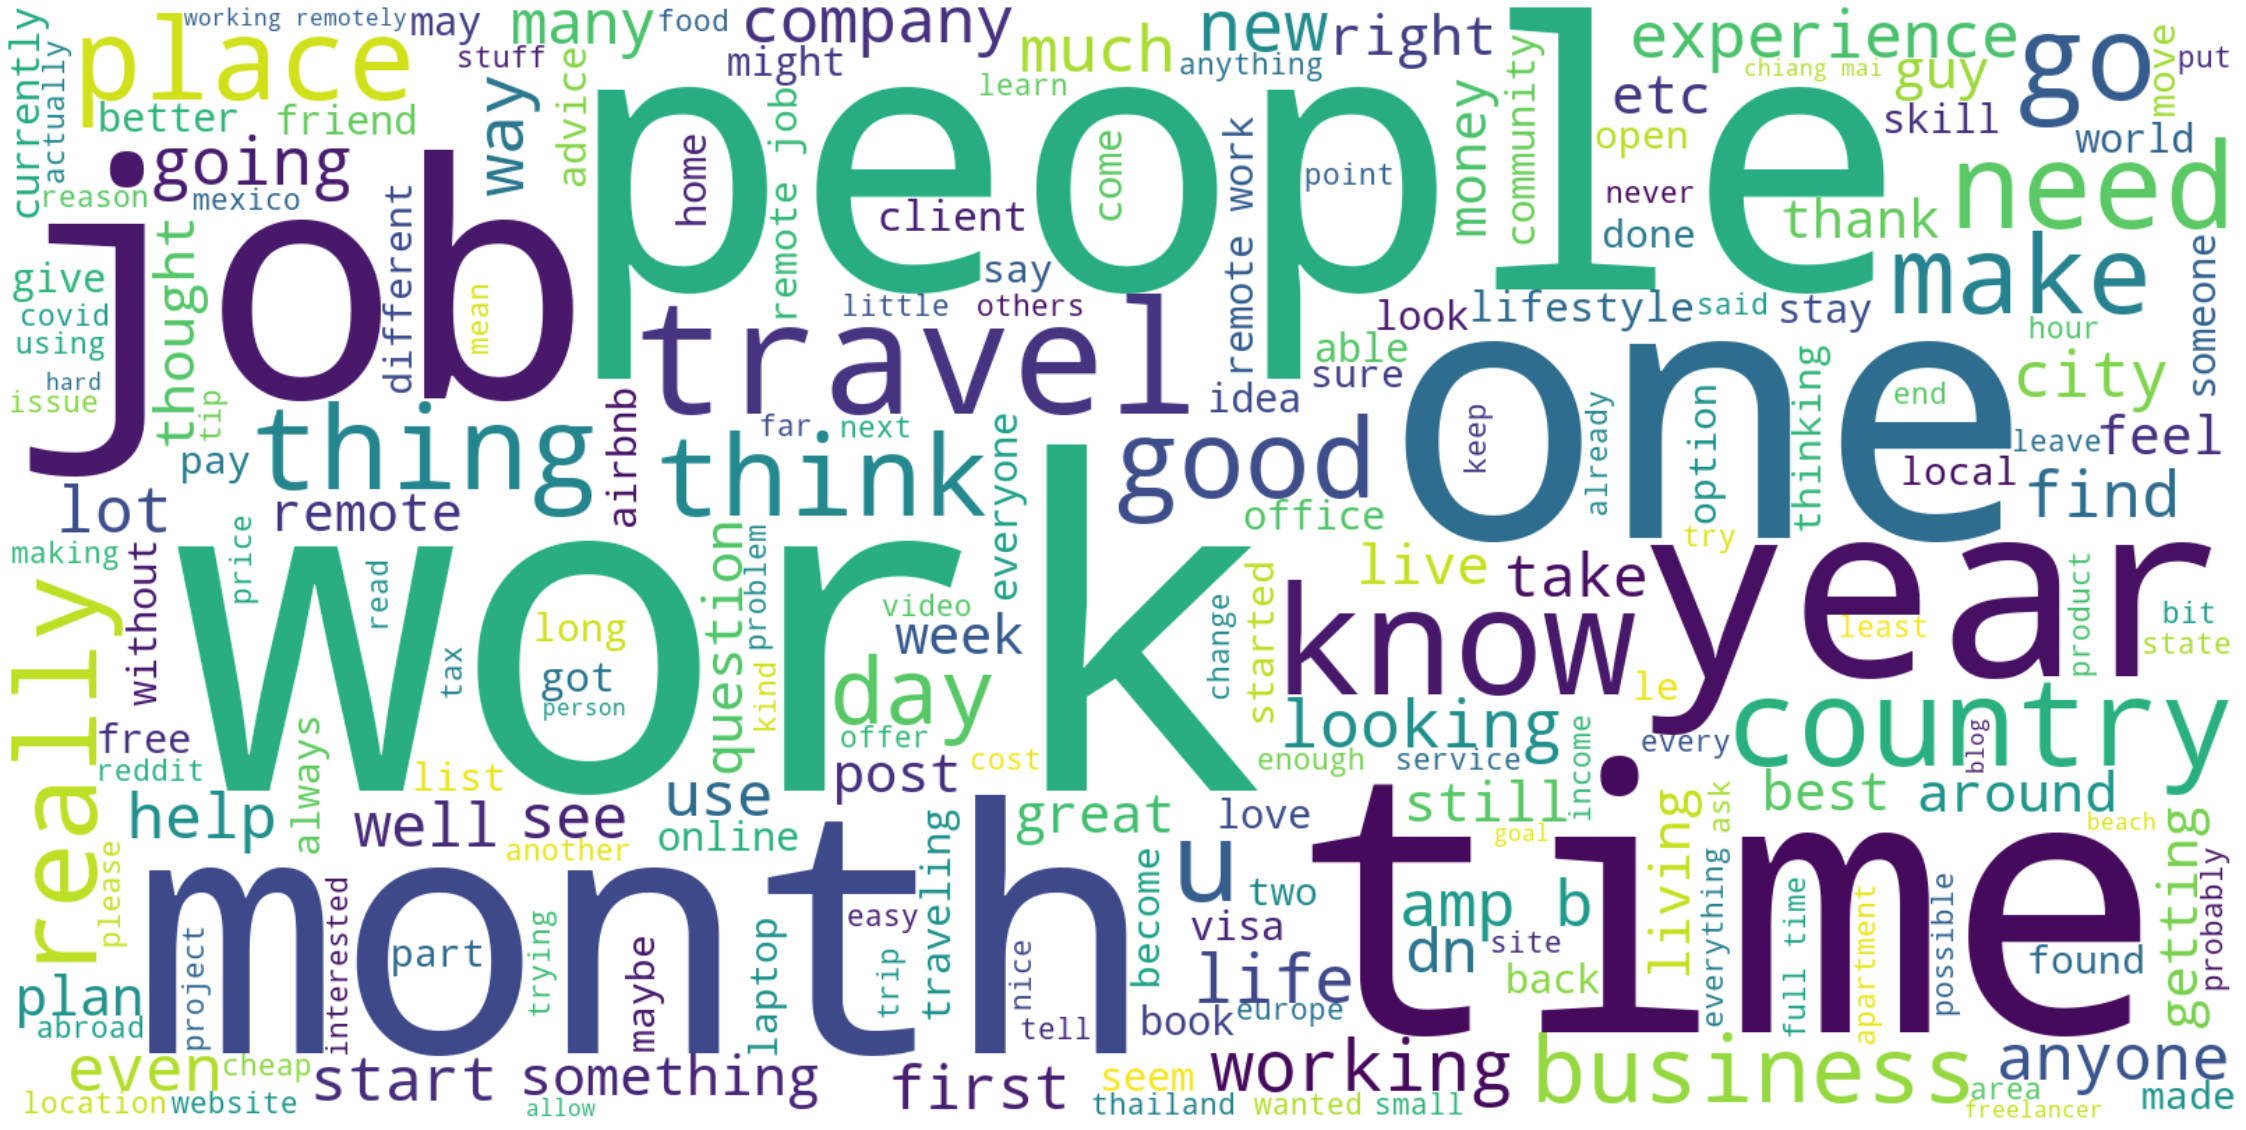

In [29]:
# Plotting wordcloud for subreddit 1
text = " ".join(meaningful_txt_1)
wordcloud = WordCloud(background_color="white", width=1600, height=800).generate(text)

# Plot
plot_cloud(wordcloud)

In [30]:
# Save the image
wordcloud.to_file("../images/digitalnomad_wc.png");

In [31]:
# Given a list of words, return a dataframe of
# word-frequency
def wordlist_to_df(wordlist):
    df = pd.DataFrame({'count': wordlist})
    return df['count'].value_counts().to_frame()

In [32]:
# Convert word frequency into dataframe
split_text = text.split()
wordfreq_1 = wordlist_to_df(split_text)

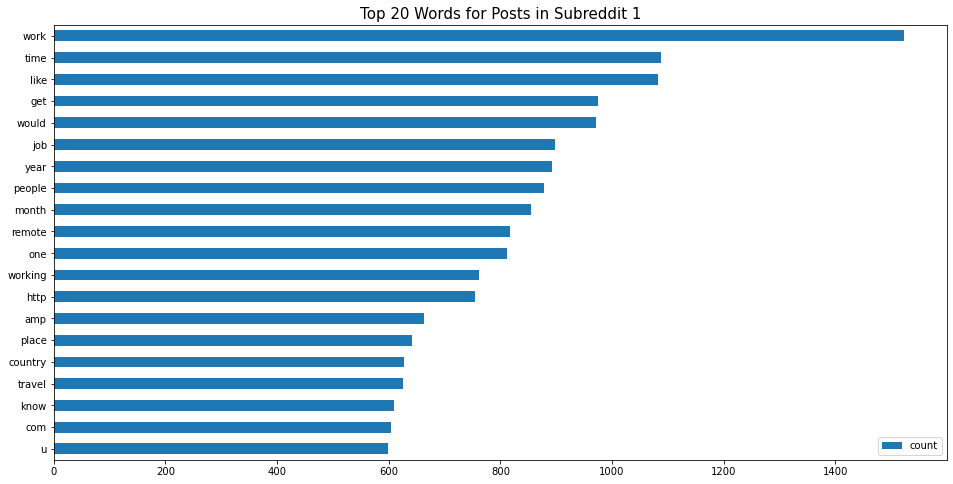

In [33]:
# Visualize top 20 words using bar plot
wordfreq_1.head(20).plot(kind='barh', figsize=(16,8))
plt.gca().invert_yaxis()
plt.title('Top 20 Words for Posts in Subreddit 1', fontsize=15);

**Observations:**  
Words such as 'work', 'time', 'job', 'travel' appear the most often in posts within Subreddit 1, which is in line with the concerns of digital nomads. People within this subreddit are often discussing about work and travel.

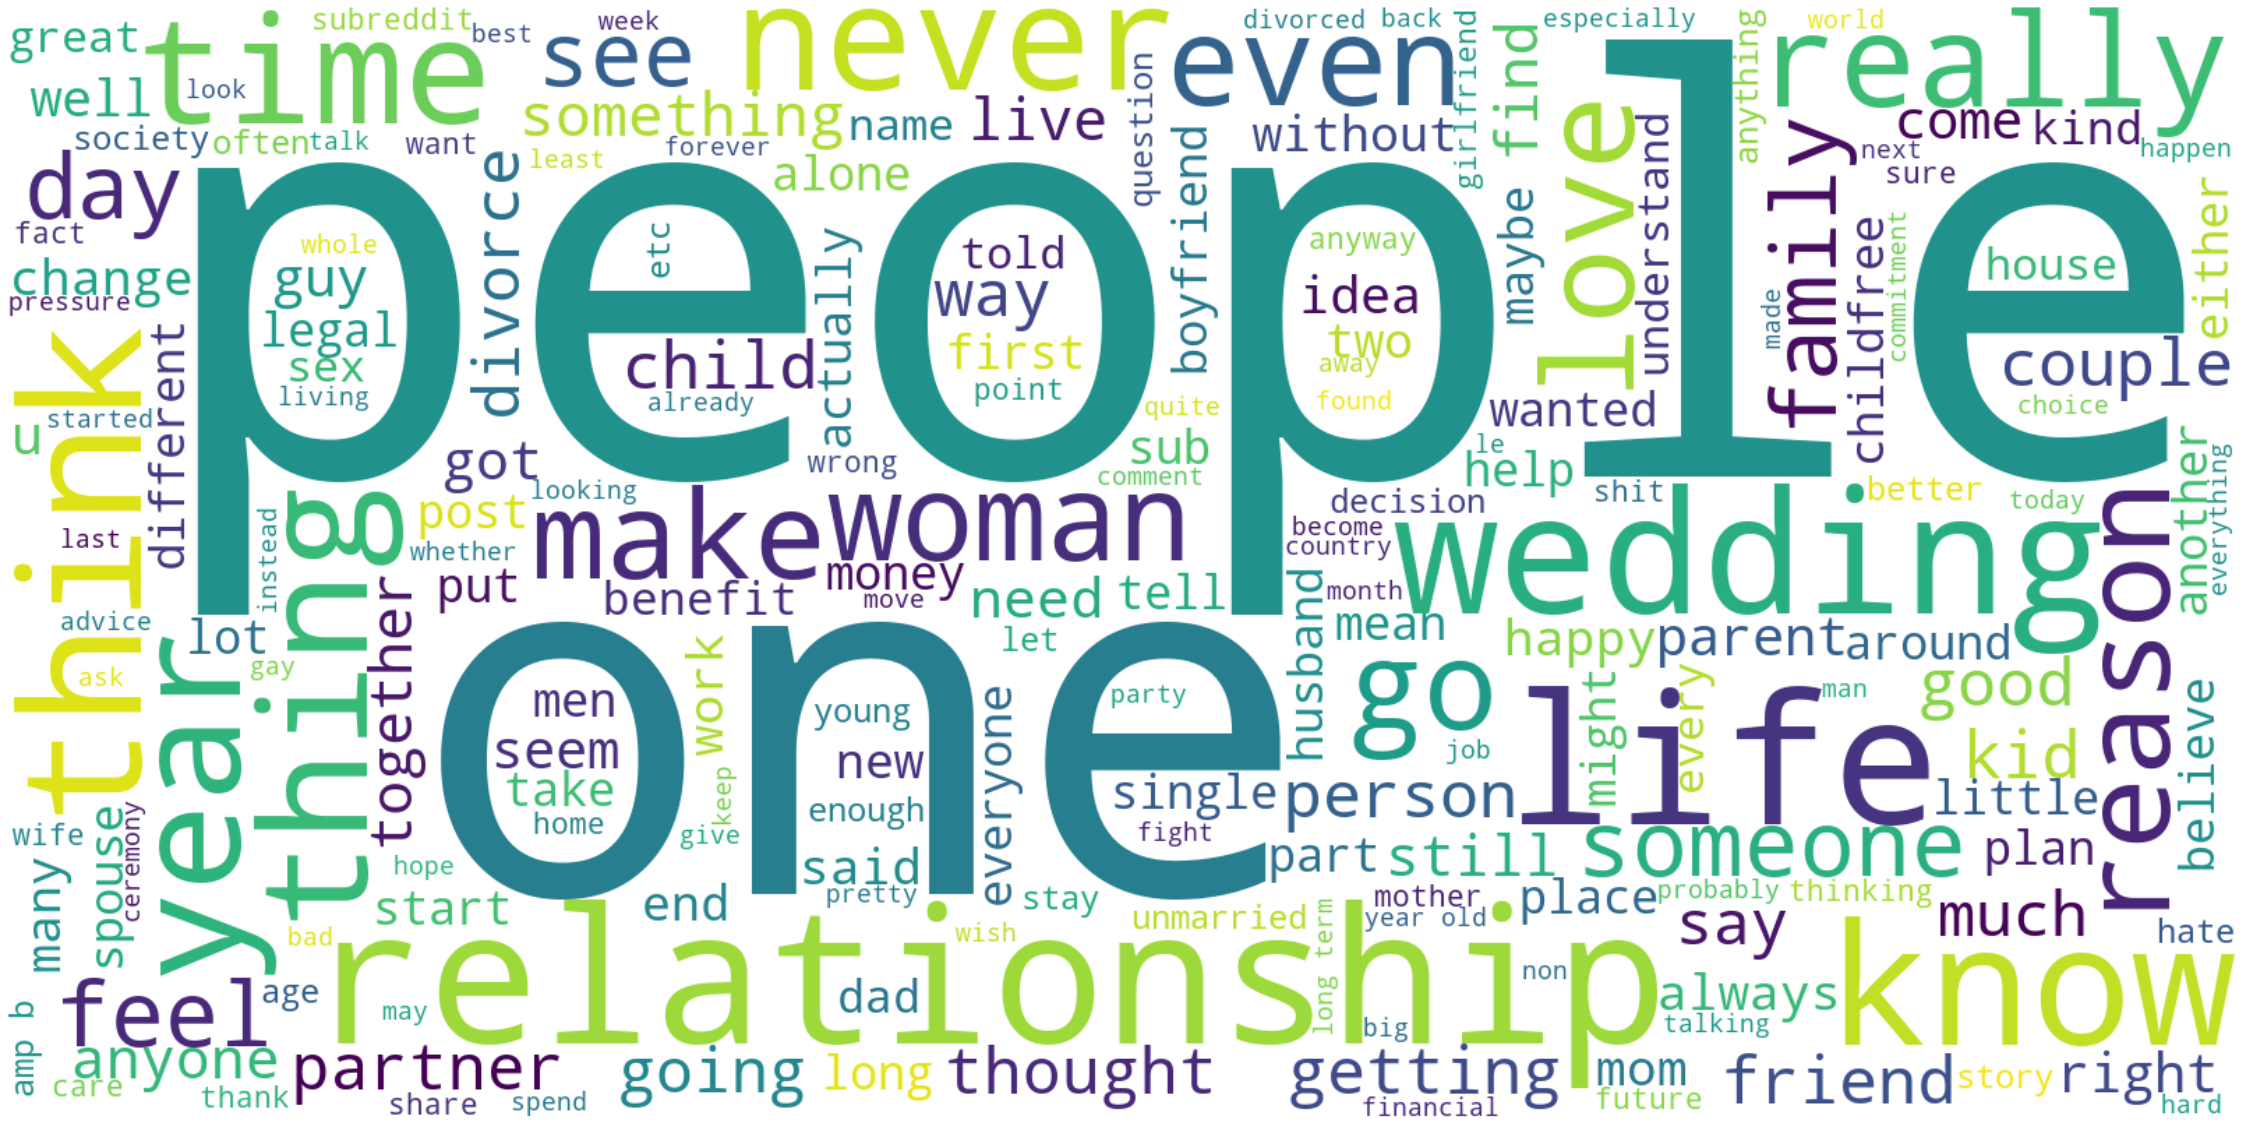

In [34]:
# Plotting wordcloud for subreddit 2
text = " ".join(meaningful_txt_2)
wordcloud = WordCloud(background_color="white", width=1600, height=800).generate(text)

# Plot
plot_cloud(wordcloud)

In [35]:
# Save the image
wordcloud.to_file("../images/marriagefree_wc.png");

In [36]:
# Convert word frequency into dataframe
split_text = text.split()
wordfreq_2 = wordlist_to_df(split_text)

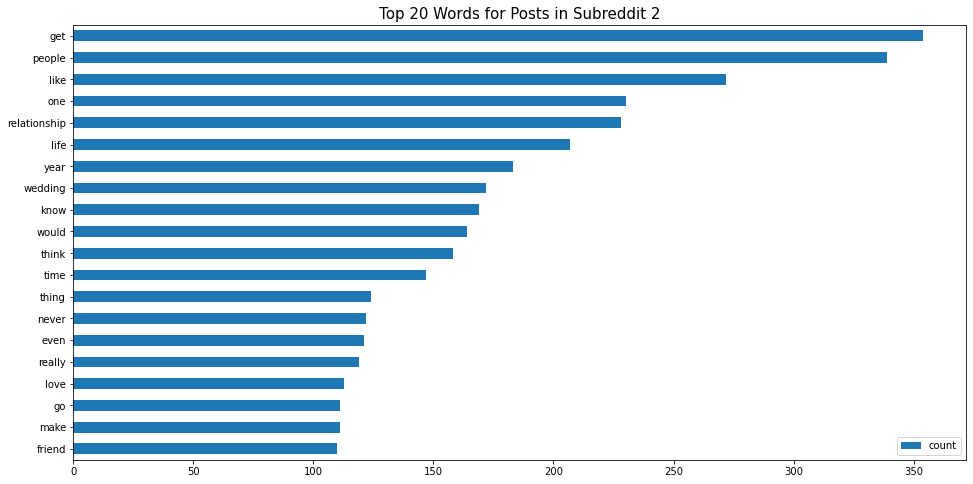

In [37]:
# Visualize top 20 words using bar plot
wordfreq_2.head(20).plot(kind='barh', figsize=(16,8))
plt.gca().invert_yaxis()
plt.title('Top 20 Words for Posts in Subreddit 2', fontsize=15);

**Observations:**  
Words such as 'people', 'relationship', 'life' appear the most often in the posts of Subreddit 2. People within this subreddit are often discussing about relationships and life. Interestingly, common words between the two subreddits are 'people', 'year', 'like'.

### Save to csv

In [38]:
# Save preprocessed texts to csv
pd.DataFrame(meaningful_txt_1, columns=['posts']).to_csv('../datasets/digitalnomad_preprocessed.csv', index=False)
pd.DataFrame(meaningful_txt_2, columns=['posts']).to_csv('../datasets/marriagefree_preprocessed.csv', index=False)